## Plot Different configuration ARE when Traffic change

- Profiler Pool
    - CAIDA 20180816, 20180621, 20180517
    - ZIPF 2a, 2b, 4

- Configuration
    | memory \ metric | 0517 | 0621 | 0816 | zipf2a | zipf2b | zipf4 | 
    |:------:|:------------:|:---------------: | :-----: | :--------------------: | :---------: | :---------: |
    | 16384  | cs r=3 w=4096   | cs r=3 w=4096   | cs r=3 w=4096   | cm r=3 w=4096  | cs r=3 w=4096  | cs r=3 w=4096  |
    | 32768  | cs r=3 w=8192   | cs r=3 w=8192   | cs r=3 w=8192   | cs r=3 w=8192  | cm r=3 w=8192  | cs r=3 w=8192  |
    | 65536  | cs r=3 w=16384  | cs r=3 w=16384  | cs r=3 w=16384  | cm r=3 w=16384 | cm r=3 w=16384 | cs r=3 w=16384 |
    

---

## Define common functions

In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json

In [3]:
def read_data(algo, row=4, width=1024, level=1, seed=1, count=1, flowkey='dstIP,dstPort', 
              epochs=['10', '20', '30'], dataset='equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/'):
    res = {}
    res[algo] = []
    for epoch in epochs:
        path = f"../../pattern_detection/lstm/SketchPatternQuery/{algo}/{dataset}/"\
                f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/data.pkl"
        # print(algo, epoch)
        with open(path, 'rb') as f:
            ll = pickle.load(f)
        res[algo].append(ll)
        # print(ll[0])
    return res

In [137]:
## Define mapping dictionary for index <---> metric
algos = ['univmon', 'cm', 'cs', 'hll', 'lc', 'mrac', 'll', 'mrb']
def get_metric_mapping(algos = ['univmon', 'cm', 'cs', 'hll']):
    mapping = {}
    for k in algos:
        mapping[k] = {}

    if 'univmon' in algos:
        # UNIV: [true_entropy, sim_entropy, sim_entropy_error, true_card, sim_card, sim_card_error, ARE]
        mapping['univmon']['hh'] = 6
        mapping['univmon']['card'] = 5 
        mapping['univmon']['entropy'] = 2
    if 'cm' in algos:
        # cm: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cm']['hh'] = 3
        mapping['cm']['entropy'] = 2
        mapping['cm']['change_det'] = 4
        mapping['cm']['fsd'] = 5
    if 'cs' in algos:
        # cs: [entropy, entropy_est, relative_entropy_error, sim_ARE_error, sim_change_detection_error, WMRD]
        mapping['cs']['hh'] = 3
        mapping['cs']['entropy'] = 2
        mapping['cs']['change_det'] = 4
        mapping['cs']['fsd'] = 5
    if 'hll' in algos:
        # hll: [true_cardinality, sim_cardinality, sim_error]
        mapping['hll']['card'] = 2
    if 'll' in algos:
        # ll: [true_cardinality, sim_cardinality, sim_error]
        mapping['ll']['card'] = 2
    if 'lc' in algos:
        # lc: [true_cardinality, sim_cardinality, sim_error]
        mapping['lc']['card'] = 2
    if 'mrac' in algos:
        # mrac: [WMRD, entropy_true, entropy_est, entropy_err]
        mapping['mrac']['fsd'] = 0
        mapping['mrac']['entropy'] = 3
    if 'mrb' in algos:
        # mrb: [true_cardinality, sim_cardinality, sim_error]
        mapping['mrb']['card'] = 2
    return mapping
mapping = get_metric_mapping(algos)

In [4]:
def get_single_result_from_pkl(algo='cm', row=3, width=4096, level=1, seeds=[1, 2, 3], 
                           count=1, measure_list='hh', flowkey="dstIP,dstPort", epochs = ['30'],
                     datasets = ['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/']):
    # key: seed, metric, row, width
    total_ret = {}
    for seed in seeds:
        total_ret[seed] = {}
        total_ret[seed][measure_list] = {}
        total_ret[seed][measure_list][row] = {}
        total_ret[seed][measure_list][row][width] = []
    # get results from all seeds
    for seed in seeds:
        for dataset in datasets:
            tmp = read_data(algo, row, width, level, seed, count, flowkey, epochs, dataset)
            # epoch
            for e in range(len(epochs)):
                # raw data
                for d in tmp[algo][e]:
                    total_ret[seed][measure_list][row][width].append(d[mapping[algo][measure_list]])
                    
    # get mean/median from all seed results
    # key: metric, row, width
    final_ret = {}               
    final_ret[measure_list] = {}
    final_ret[measure_list][row] = {}
    final_ret[measure_list][row][width] = []
    
    arr = None
    for seed in seeds:
        if arr is None:
            arr = total_ret[seed][measure_list][row][width]
        else:
            arr = np.vstack([arr, total_ret[seed][measure_list][row][width]])
    # get mean value from all seeds
    final_ret[measure_list][row][width] = np.mean(arr, axis=0).tolist()
    
    return final_ret


In [5]:
def get_counter_size(algo = 'cm'):
    counter_size = 4
    if algo == 'hll' or algo == 'll':
        # int8
        counter_size = 1
    elif algo == 'lc' or algo == 'mrb':
        # 1 bit
        counter_size = 1/8
    return counter_size

# The original width is the number of counter, so it needs to multiply the size of the counter
def convert_width_to_real_byte(algo = 'cm', width=4096):
    counter_size = get_counter_size(algo)
    return width * counter_size

In [6]:
def get_mean_value(ret, row=3, measure_list='hh'):
    data = 0.0
    for w in ret[measure_list][row]:
        data = np.mean(ret[measure_list][row][w])
    return data


In [151]:
def plot_impact_of_traffic(algos=['cs', 'cs', 'cm', 'cm', 'cm'], rows = [3, 3, 3, 3, 3], widths = [8192, 16384, 32768, 65536, 131072],
                           level=[1, 1, 1, 1, 1], seeds=[1,2,3], count=1, measure_list='hh', flowkey='srcIP', epochs = ['30'],
                           datasets = [['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/'],
                                       ['equinix-nyc.dirA.20180816-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-130500.UTC.anon.pcap/']],
                           mem_constraint=[32768, 65536, 131072, 262144, 524288]):

    # get the mean result of the given metric 
    size = len(algos)
    data = {}
    dataset_name = []
    for dataset in datasets:
        # get dataset name
        if len(dataset) > 1:
            dataset_name.append(dataset[0][17:25])
        else: # for synthetic pcap file
            dataset_name.append(dataset[0]) 
        
        # get mean result
        data[dataset_name[-1]] = []
        for i in range(size):
            ret = get_single_result_from_pkl(algos[i], rows[i], widths[i], level[i], seeds, count, measure_list, flowkey, epochs, dataset)
            mean_ret = get_mean_value(ret, rows[i], measure_list)
            data[dataset_name[-1]].append(mean_ret)
        
    print(data)
        
    # plot the figure
    x_labels = []
    for w in mem_constraint:
        w = convert_width_to_real_byte(algos[0], w)
        x_labels.append(str(int(w / 1024)))
        
    fig = plt.figure(figsize = (7, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    for date, val in data.items():
        bp = ax.plot(mem_constraint, val, label=date)

    # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

    ax.set_xticks(mem_constraint)
    
    ax.set_xticklabels(x_labels, fontsize=12)
    plt.xlabel("Width (KB)", fontsize=16)
        
    plt.yticks(fontsize=14)
        
    title_str = ''
    ylabel_str = ''
    ylabel_fontsize = 16
    if measure_list == 'hh':
        title_str = 'Heavy Hitter'
        ylabel_str = "Average Relative Error (%)"
    elif measure_list == 'entropy':
        title_str = 'Entropy'
        ylabel_str = "Relative Error (%)"
    elif measure_list == 'card':
        title_str = 'Cardinality'
        ylabel_str = "Relative Error (%)"
    elif measure_list == 'fsd':
        title_str = 'Flow Size Distribution'
        ylabel_str = "Weighted Mean Relative Difference (WMRD)"
        ylabel_fontsize = 14
    elif measure_list == 'change_det':
        title_str = 'Change Detection'
        ylabel_str = "Average Relative Error (%)"

    # if level > 1:
    #     title_str += f', Level: {level}'
    plt.title(title_str, fontsize=18)
    plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

    plt.legend(fontsize=16)
    
    # if isSaveFig:
    #     plt.savefig(f'figures/profiler/{algo.upper()}_{m}_profiling.png', format='png', bbox_inches='tight')
    
    # show plot
    plt.show()
        
# plot_impact_of_traffic()

In [ ]:
def plot_reconfig_scatter(algos=['cs', 'cs', 'cm', 'cm', 'cm'], rows = [3, 3, 3, 3, 3], widths = [8192, 16384, 32768, 65536, 131072],
                           level=[1, 1, 1, 1, 1], seeds=[1,2,3], count=1, measure_list='hh', flowkey='srcIP', epochs = ['30'],
                           datasets = [['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/'],
                                       ['equinix-nyc.dirA.20180816-130100.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-130500.UTC.anon.pcap/']],
                           mem_constraint=[32768, 65536, 131072, 262144, 524288]):

    # get the mean result of the given metric 
    size = len(algos)
    data = {}
    dataset_name = []
    for dataset in datasets:
        # get dataset name
        if len(dataset) > 1:
            dataset_name.append(dataset[0][17:25])
        else: # for synthetic pcap file
            dataset_name.append(dataset[0]) 
        
        # get mean result
        data[dataset_name[-1]] = []
        for i in range(size):
            ret = get_single_result_from_pkl(algos[i], rows[i], widths[i], level[i], seeds, count, measure_list, flowkey, epochs, dataset)
            mean_ret = get_mean_value(ret, rows[i], measure_list)
            data[dataset_name[-1]].append(mean_ret)
        
    print(data)
        
    # plot the figure
    x_labels = []
    for w in mem_constraint:
        w = convert_width_to_real_byte(algos[0], w)
        x_labels.append(str(int(w / 1024)))
        
    fig = plt.figure(figsize = (7, 5))

    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])

    # Creating plot
    for date, val in data.items():
        bp = ax.plot(mem_constraint, val, label=date)

    # plt.axvline(x = 8192, color = 'darkgreen', linestyle='--')

    ax.set_xticks(mem_constraint)
    
    ax.set_xticklabels(x_labels, fontsize=12)
    plt.xlabel("Width (KB)", fontsize=16)
        
    plt.yticks(fontsize=14)
        
    title_str = ''
    ylabel_str = ''
    ylabel_fontsize = 16
    if measure_list == 'hh':
        title_str = 'Heavy Hitter'
        ylabel_str = "Average Relative Error (%)"
    elif measure_list == 'entropy':
        title_str = 'Entropy'
        ylabel_str = "Relative Error (%)"
    elif measure_list == 'card':
        title_str = 'Cardinality'
        ylabel_str = "Relative Error (%)"
    elif measure_list == 'fsd':
        title_str = 'Flow Size Distribution'
        ylabel_str = "Weighted Mean Relative Difference (WMRD)"
        ylabel_fontsize = 14
    elif measure_list == 'change_det':
        title_str = 'Change Detection'
        ylabel_str = "Average Relative Error (%)"

    # if level > 1:
    #     title_str += f', Level: {level}'
    plt.title(title_str, fontsize=18)
    plt.ylabel(ylabel_str, fontsize=ylabel_fontsize)

    plt.legend(fontsize=16)
    
    # if isSaveFig:
    #     plt.savefig(f'figures/profiler/{algo.upper()}_{m}_profiling.png', format='png', bbox_inches='tight')
    
    # show plot
    plt.show()
        
# plot_impact_of_traffic()

### Common Variable


In [158]:
## Hyperparameters
isSaveFig = False
isDumpJson = True
isBoxPlot = False
isShowByte = False

seeds = [1, 2, 3]
mem_constraint=[32768, 65536, 131072, 262144, 524288]

datasets = [['equinix-nyc.dirA.20180517-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180517-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180517-140000.UTC.anon.pcap/'],
            ['equinix-nyc.dirA.20180621-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180621-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180621-140000.UTC.anon.pcap/'],
            ['equinix-nyc.dirA.20180816-130100.UTC.anon.pcap/', 
             'equinix-nyc.dirA.20180816-130500.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-133000.UTC.anon.pcap/',
             'equinix-nyc.dirA.20180816-140000.UTC.anon.pcap/'],]



---

### Heavy Hitter

{'20180517': [2.1071784393076043, 0.9237888968239286, 0.20071503989453982, 0.055643318164442526, 0.014861724155102618], '20180621': [2.1698378588018166, 0.8726279053134327, 0.18250305687510918, 0.04783300844868874, 0.011907452377214234], '20180816': [2.432670652859726, 1.1175741081930268, 0.20021592974743802, 0.05087084795273049, 0.01195211821692262]}


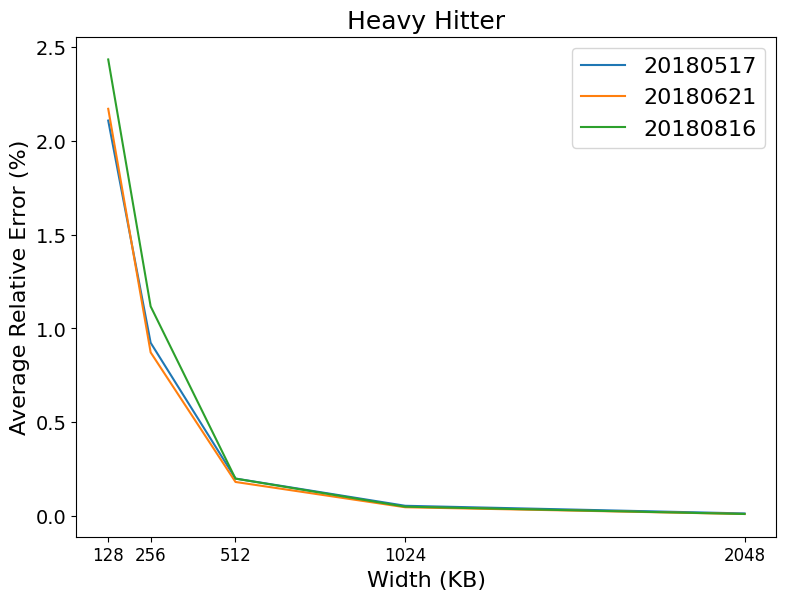

In [159]:
algos = ['cs', 'cs', 'cm', 'cm', 'cm']
rows = [3, 3, 3, 3, 3]
widths = [8192, 16384, 32768, 65536, 131072]
level=[1, 1, 1, 1, 1]
count=1
measure_list='hh'
flowkey='srcIP'
epochs = ['30']

plot_impact_of_traffic(algos, rows, widths, level, seeds, count, measure_list, flowkey, epochs, datasets, mem_constraint)

---

### Change Detection

{'20180517': [4.408438698541798, 2.7690001644973767, 2.3975988907739563, 2.270925339708766, 2.232499411864582], '20180621': [4.251459726152814, 2.5989232666446513, 2.263008970765104, 2.1303994930036345, 2.090877964863684], '20180816': [4.8915592236379, 3.037859997110441, 2.629806322258769, 2.4887135237508917, 2.452500245092266]}


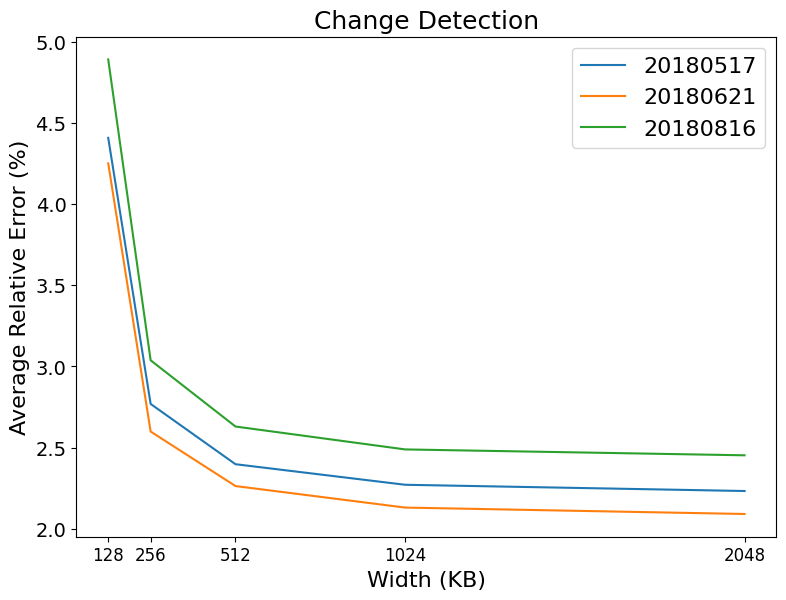

In [160]:
algos = ['cs', 'cm', 'cm', 'cm', 'cm']
rows = [3, 3, 3, 3, 3]
widths = [8192, 16384, 32768, 65536, 131072]
level=[1, 1, 1, 1, 1]
count=1
measure_list='change_det'
flowkey='srcIP'
epochs = ['30']

plot_impact_of_traffic(algos, rows, widths, level, seeds, count, measure_list, flowkey, epochs, datasets, mem_constraint)

---

### Entropy

{'20180517': [7.045702808235971, 4.553484588062073, 2.800143154882075, 1.635983149805241, 2.830931603293918], '20180621': [7.159558406630856, 4.613043065277582, 2.8329991433599058, 1.6491680234791706, 3.183136550237463], '20180816': [7.158719946291946, 4.586106223194014, 2.818740194062207, 1.6386456208921643, 2.311160605222984]}


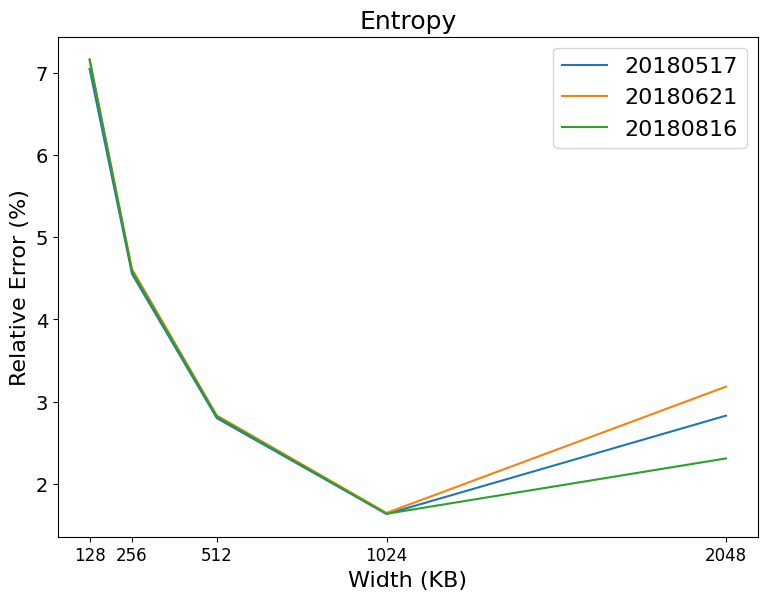

In [161]:
algos = ['mrac', 'mrac', 'mrac', 'mrac', 'univmon']
rows = [1, 1, 1, 1, 3]
widths = [4096, 8192, 16384, 32768, 8192]
level=[8, 8, 8, 8, 16]
count=1
measure_list='entropy'
flowkey='srcIP'
epochs = ['30']

plot_impact_of_traffic(algos, rows, widths, level, seeds, count, measure_list, flowkey, epochs, datasets, mem_constraint)

---

### Flow Size Distribution

{'20180517': [0.7400821718278566, 0.4466361993134714, 0.4149268194230612, 0.39448210535860556, 0.37731918781086404], '20180621': [0.7387805718702046, 0.4457268947562092, 0.4206534809931319, 0.3949704211735741, 0.37724500340003414], '20180816': [0.7476631601697598, 0.44835158023120025, 0.42430399944016617, 0.39892414536762894, 0.3819428872554226]}


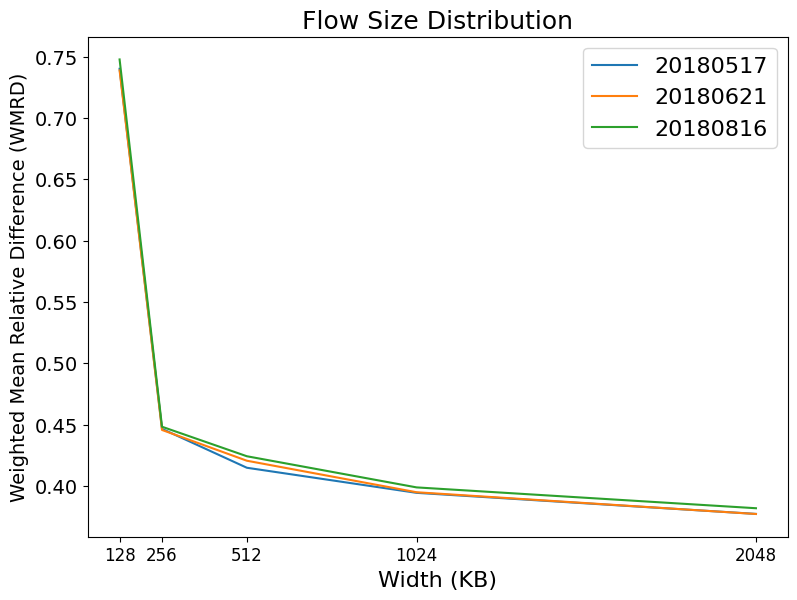

In [162]:
algos = ['mrac', 'mrac', 'mrac', 'mrac', 'mrac']
rows = [1, 1, 1, 1, 1]
widths = [4096, 8192, 16384, 32768, 65536]
level=[8, 8, 8, 8, 8]
count=1
measure_list='fsd'
flowkey='srcIP'
epochs = ['30']

plot_impact_of_traffic(algos, rows, widths, level, seeds, count, measure_list, flowkey, epochs, datasets, mem_constraint)

---

### Cardinality

{'20180517': [1.855101112123507, 1.855101112123507, 1.855101112123507, 1.855101112123507, 0.5066906224720757], '20180621': [1.7865047631834643, 1.7865047631834643, 1.7865047631834643, 1.7865047631834643, 0.37870960365516526], '20180816': [1.7694572501290158, 1.7694572501290158, 1.7694572501290158, 1.7694572501290158, 0.35103262821770587]}


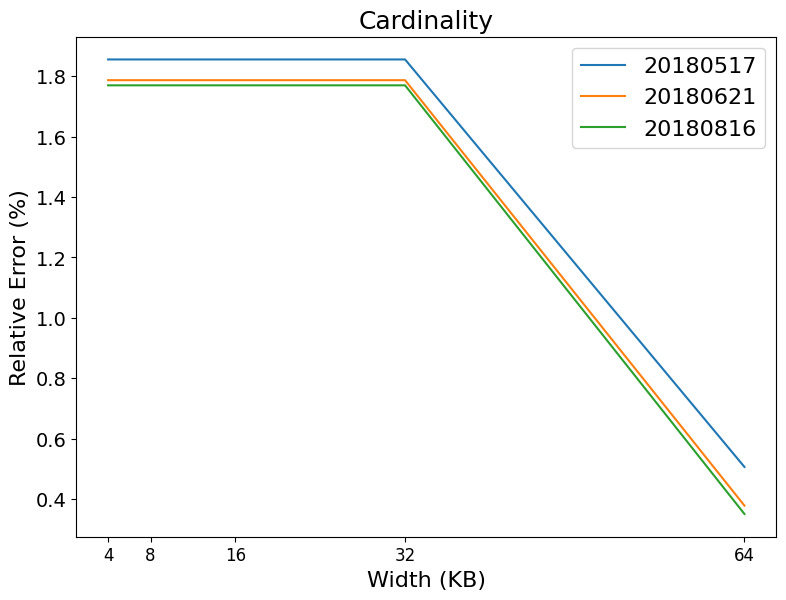

In [163]:
algos = ['lc', 'lc', 'lc', 'lc', 'lc']
rows = [1, 1, 1, 1, 1]
widths = [32768, 32768, 32768, 32768, 65536]
level=[1, 1, 1, 1, 1]
count=1
measure_list='card'
flowkey='srcIP'
epochs = ['30']

plot_impact_of_traffic(algos, rows, widths, level, seeds, count, measure_list, flowkey, epochs, datasets, mem_constraint)

## Plot scatter

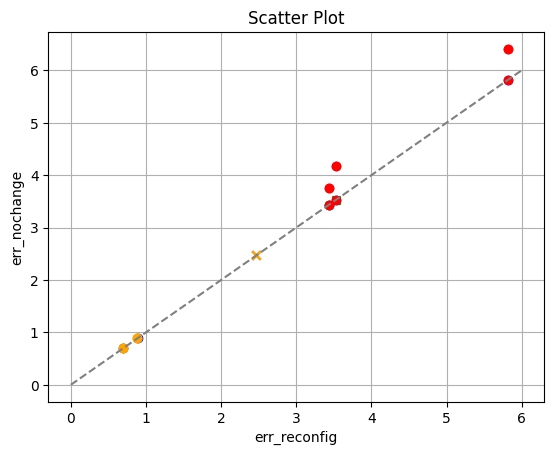

In [22]:
# no change
n_detect = [1,1,1,1,0,1]
n_x = [3.43, 3.53, 5.82, 0.90, 2.47, 0.70]
n_y = [3.43, 3.53, 5.82, 0.90, 2.47, 0.70]

# caida + caida
cc_detect = [1, 0]
cc_x = [3.43, 3.53]
cc_y = [3.43, 3.53]

# caida + zipf
cz_detect = [1,1,0,1,1,1,1,0,0]
cz_x = [0.88, 0.70, 2.47, 0.88, 0.88, 0.70, 0.70, 2.47, 2.47]
cz_y = [0.90, 0.70, 2.47, 0.90, 0.90, 0.70, 0.70, 2.47, 2.47]

# zipf + caida
zc_detect = [1,1,1,1,1,1,1,1,1]
zc_x = [5.82, 3.43, 5.82, 3.43, 5.82, 3.43, 3.53, 3.53, 3.53]
zc_y = [6.41, 3.76, 5.82, 3.43, 6.41, 3.76, 4.18, 3.53, 4.18]

# Plot scatter for No change
for i in range(len(n_detect)):
    if n_detect[i] == 1:
        plt.scatter(n_x[i], n_y[i], marker='o', color='blue')
    else:
        plt.scatter(n_x[i], n_y[i], marker='x', color='blue')

# Plot scatter for caida + caida
for i in range(len(cc_detect)):
    if cc_detect[i] == 1:
        plt.scatter(cc_x[i], cc_y[i], marker='o', color='green')
    else:
        plt.scatter(cc_x[i], cc_y[i], marker='x', color='green')

# Plot scatter for caida + zipf
for i in range(len(cz_detect)):
    if cz_detect[i] == 1:
        plt.scatter(cz_x[i], cz_y[i], marker='o', color='orange')
    else:
        plt.scatter(cz_x[i], cz_y[i], marker='x', color='orange')

# Plot scatter for zipf + caida
for i in range(len(zc_detect)):
    if zc_detect[i] == 1:
        plt.scatter(zc_x[i], zc_y[i], marker='o', color='red')
    else:
        plt.scatter(zc_x[i], zc_y[i], marker='x', color='red')
        
line_x = [0, 1, 2, 3, 4, 5, 6]
line_y = [0, 1, 2, 3, 4, 5, 6]
plt.plot(line_x, line_y, color='gray', linestyle='--')
plt.grid()


# Add labels and title
plt.xlabel('err_reconfig')
plt.ylabel('err_nochange')
plt.title('Scatter Plot')

# Show plot
plt.show()

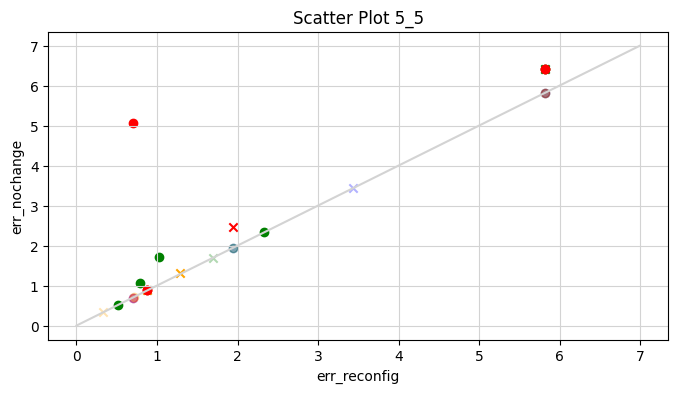

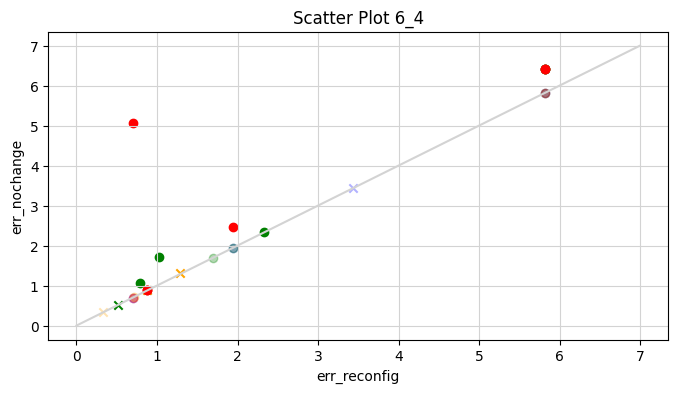

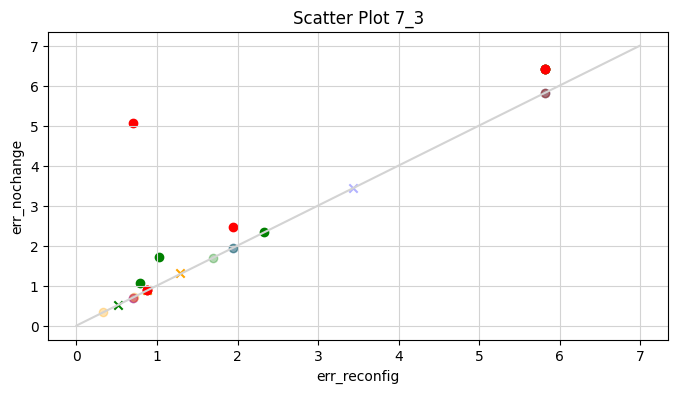

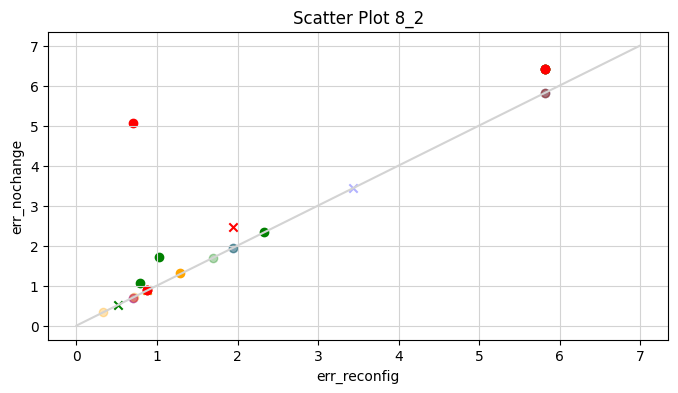

In [7]:
# single dataset
n_detect = [[0,1,0,1,1]]
n_x = [3.43, 5.82, 0.88, 1.94, 0.70]
n_y = [3.43, 5.82, 0.88, 1.94, 0.70]

# same dist, diff tfs
cc_detect = [[1,1,0,1,0,1,1,1,1,1], [1,1,1,1,1,1,1,1,1,0], [1,1,1,1,1,1,1,1,1,0], [1,1,1,1,1,1,1,1,1,0]]
cc_x = [2.33, 5.82, 1.70, 5.82, 5.82, 1.03, 1.94, 0.88, 0.79, 0.51]
cc_y = [2.35, 6.41, 1.70, 5.82, 6.41, 1.72, 1.94, 0.88, 1.06, 0.52]

# diff dist, same tfs
cz_detect = [[0,0,1,0], [0,0,1,0], [0,0,1,1], [0,1,1,1]]
cz_x = [0.88, 1.29, 0.71, 0.33]
cz_y = [0.90, 1.32, 0.71, 0.33]

# diff dist, diff tfs
zc_detect = [[1,1,0,1,1,1,1,1],[1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1],[1,1,0,1,1,1,1,1]]
zc_x = [0.88, 5.82, 1.94, 5.82, 0.70, 5.82, 0.70, 0.88]
zc_y = [0.90, 6.41, 2.47, 6.41, 0.70, 5.82, 5.06, 0.90]

label = ["5_5", "6_4", "7_3", "8_2"]
for j in range(4):
    plt.figure(figsize=(8, 4))
    # single dataset
    for i in range(len(n_detect[0])):
        if n_detect[0][i] == 1:
            if n_x[i] == n_y[i]:
                plt.scatter(n_x[i], n_y[i], marker='o', color='blue', alpha=0.3)
            else:
                plt.scatter(n_x[i], n_y[i], marker='o', color='blue')
        else:
            if n_x[i] == n_y[i]:
                plt.scatter(n_x[i], n_y[i], marker='x', color='blue', alpha=0.3)
            else:
                plt.scatter(n_x[i], n_y[i], marker='x', color='blue')

    # same dist, diff tfs
    for i in range(len(cc_detect[j])):
        if cc_detect[j][i] == 1:
            if cc_x[i] == cc_y[i]:
                plt.scatter(cc_x[i], cc_y[i], marker='o', color='green', alpha=0.3)
            else:
                plt.scatter(cc_x[i], cc_y[i], marker='o', color='green')
        else:
            if cc_x[i] == cc_y[i]:
                plt.scatter(cc_x[i], cc_y[i], marker='x', color='green', alpha=0.3)
            else:
                plt.scatter(cc_x[i], cc_y[i], marker='x', color='green')

    # diff dist, same tfs
    for i in range(len(cz_detect[j])):
        if cz_detect[j][i] == 1:
            if cz_x[i] == cz_y[i]:
                plt.scatter(cz_x[i], cz_y[i], marker='o', color='orange', alpha=0.3)
            else:
                plt.scatter(cz_x[i], cz_y[i], marker='o', color='orange')
        else:
            if cz_x[i] == cz_y[i]:
                plt.scatter(cz_x[i], cz_y[i], marker='x', color='orange', alpha=0.3)
            else:
                plt.scatter(cz_x[i], cz_y[i], marker='x', color='orange')

    # diff dist, diff tfs
    for i in range(len(zc_detect[j])):
        if zc_detect[j][i] == 1:
            if zc_x[i] == zc_y[i]:
                plt.scatter(zc_x[i], zc_y[i], marker='o', color='red', alpha=0.3)
            else:
                plt.scatter(zc_x[i], zc_y[i], marker='o', color='red')
        else:
            if zc_x[i] == zc_y[i]:
                plt.scatter(zc_x[i], zc_y[i], marker='x', color='red', alpha=0.3)
            else:
                plt.scatter(zc_x[i], zc_y[i], marker='x', color='red')
            
    line_x = [0, 1, 2, 3, 4, 5, 6, 7]
    line_y = [0, 1, 2, 3, 4, 5, 6, 7]
    plt.plot(line_x, line_y, color='lightgray', linestyle='-')
    plt.grid(color="lightgray")


    # Add labels and title
    plt.xlabel('err_reconfig')
    plt.ylabel('err_nochange')
    plt.title('Scatter Plot %s' % label[j])

    # Show plot
    plt.show()

In [9]:
def get_ARE(a, ai, b, bi):
    # ARE
    dict = {}
    
    dict["caida0517"] = [[3.76, 2.11, 1.03], [3.43, 1.70, 1.72]]
    dict["caida0816"] = [[6.41, 2.33, 1.32], [5.82, 2.35, 1.29]]
    dict["zipf2a"] = [[0.88, 0.52, 0.43], [0.90, 0.51, 0.33]]
    dict["zipf2b"] = [[1.94, 1.43, 0.79], [2.47, 1.43, 1.06]]
    dict["zipf4"] = [[5.06, 4.68, 5.05], [0.70, 0.71, 0.98]]
    
    idx = 0
    if dict[a][0][ai] < dict[a][1][ai]:
        idx = 0
    else:
        idx = 1
        
    idx2 = 0
    if dict[b][0][bi] < dict[b][1][bi]:
        idx2 = 0
    else:
        idx2 = 1
        
    x = dict[b][idx2][bi]
    y = dict[b][idx][bi]
        
    return x, y


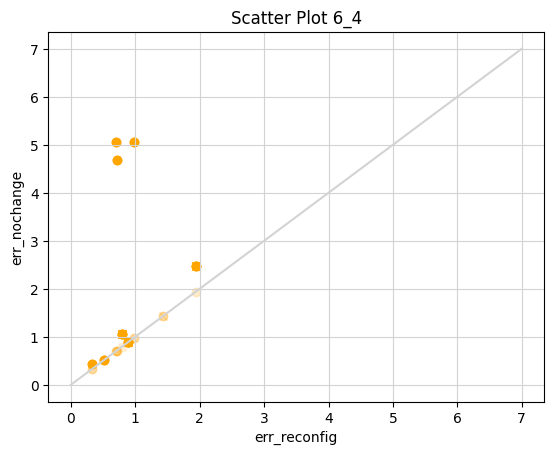

In [62]:

# caida0517 = ["caida0517-500w", "caida0517-250w", "caida0517-125w"]
# caida0816 = ["caida0816-600w", "caida0816-300w", "caida0816-150w"]
# zipf2a = ["zipf2a-150w", "zipf2a-75w", "zipf2a-35w"]
# zipf2b = ["zipf2b-40w", "zipf2b-20w", "zipf2b-10w"]
# zipf4 = ["zipf4-60w", "zipf4-30w", "zipf4-15w"]
datasets = ["caida0517", "caida0816", "zipf2a", "zipf2b", "zipf4"]


# single dataset
n_detect = [0,0,0,1,1,1,0,0,1,1,1,1,1,1,1]
n_x = []
n_y = []
for d in datasets:
    for i in range(3):
        v1, v2 = get_ARE(d,i,d,i)
        n_x.append(v1)     
        n_y.append(v2)     
        

# same dist, CAIDA
s_detect = []
c_detect = [0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1]
# c_detect = []
cc_x = []
cc_y = []
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[0], i, datasets[1], j)
        cc_x.append(v1)
        cc_y.append(v2)
        
        v1, v2 = get_ARE(datasets[1], i, datasets[0], j)
        cc_x.append(v1)
        cc_y.append(v2)
        
# same dist, zipf
z_detect = [1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[2], i, datasets[3], j)
        cc_x.append(v1)
        cc_y.append(v2)
        
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[3], i, datasets[2], j)
        cc_x.append(v1)
        cc_y.append(v2)

s_detect = c_detect + z_detect
# print(s_detect)

# diff dist, caida + zipf
cz_detect = []
cz1_detect = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1]
cz_x = []
cz_y = []
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[0], i, datasets[2], j)
        cz_x.append(v1)
        cz_y.append(v2)
for i in range(3):
    for j in range(3):        
        v1, v2 = get_ARE(datasets[1], i, datasets[2], j)
        cz_x.append(v1)
        cz_y.append(v2)
        
cz2_detect = [0,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[0], i, datasets[3], j)
        cz_x.append(v1)
        cz_y.append(v2)
for i in range(3):
    for j in range(3):        
        v1, v2 = get_ARE(datasets[1], i, datasets[3], j)
        cz_x.append(v1)
        cz_y.append(v2)
        
cz3_detect = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[0], i, datasets[4], j)
        cz_x.append(v1)
        cz_y.append(v2)
for i in range(3):
    for j in range(3):        
        v1, v2 = get_ARE(datasets[1], i, datasets[4], j)
        cz_x.append(v1)
        cz_y.append(v2)
        
cz_detect = cz1_detect + cz2_detect + cz3_detect
    
# diff dist, zipf + caida
zc_detect = []
zc1_detect = [1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
zc_x = []
zc_y = []
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[2], i, datasets[0], j)
        zc_x.append(v1)
        zc_y.append(v2)
             
        v1, v2 = get_ARE(datasets[2], i, datasets[1], j)
        zc_x.append(v1)
        zc_y.append(v2)
        
zc2_detect = [1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[3], i, datasets[0], j)
        zc_x.append(v1)
        zc_y.append(v2)
             
        v1, v2 = get_ARE(datasets[3], i, datasets[1], j)
        zc_x.append(v1)
        zc_y.append(v2)
        
zc3_detect = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[4], i, datasets[0], j)
        zc_x.append(v1)
        zc_y.append(v2)
             
        v1, v2 = get_ARE(datasets[4], i, datasets[1], j)
        zc_x.append(v1)
        zc_y.append(v2)
        
zc_detect = zc1_detect + zc2_detect + zc3_detect

# diff dist, zipf2a zipf4
zz_detect = []
zz1_detect = [1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1]
zz_x = []
zz_y = []
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[2], i, datasets[4], j)
        zz_x.append(v1)
        zz_y.append(v2)
        
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[4], i, datasets[2], j)
        zz_x.append(v1)
        zz_y.append(v2)
        
# diff dist, zipf2b zipf4
zz2_detect = [1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1]
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[3], i, datasets[4], j)
        zz_x.append(v1)
        zz_y.append(v2)
        
for i in range(3):
    for j in range(3):
        v1, v2 = get_ARE(datasets[4], i, datasets[3], j)
        zz_x.append(v1)
        zz_y.append(v2)
        
zz_detect = zz1_detect + zz2_detect

# label = ["5_5", "6_4", "7_3", "8_2"]
# plt.figure(figsize=(8, 4))

# # single dataset
# for i in range(len(n_detect)):
#     if n_detect[i] == 1:
#         if n_x[i] == n_y[i]:
#             # continue
#             plt.scatter(n_x[i], n_y[i], marker='o', color='blue', alpha=0.1)
#         else:
#             plt.scatter(n_x[i], n_y[i], marker='o', color='blue', label="single dataset")
#     else:
#         if n_x[i] == n_y[i]:
#             # continue
#             plt.scatter(n_x[i], n_y[i], marker='x', color='blue', alpha=0.1)
#         else:
#             plt.scatter(n_x[i], n_y[i], marker='x', color='blue', label="single dataset")
            

# # same dist
# for i in range(len(s_detect)):
#     if s_detect[i] == 1:
#         if cc_x[i] == cc_y[i]:
#             # continue
#             plt.scatter(cc_x[i], cc_y[i], marker='o', color='green', alpha=0.1)
#         else:
#             plt.scatter(cc_x[i], cc_y[i], marker='o', color='green', label="same dist.")
#     else:
#         if cc_x[i] == cc_y[i]:
#             # continue
#             plt.scatter(cc_x[i], cc_y[i], marker='x', color='green', alpha=0.1)
#         else:
#             plt.scatter(cc_x[i], cc_y[i], marker='x', color='green')

# # diff dist, caida + zipf
# for i in range(len(cz_detect)):
#     if cz_detect[i] == 1:
#         if cz_x[i] == cz_y[i]:
#             # continue
#             plt.scatter(cz_x[i], cz_y[i], marker='o', color='orange', alpha=0.1)
#         else:
#             plt.scatter(cz_x[i], cz_y[i], marker='o', color='orange', label="diff dist., c+z")
#     else:
#         if cz_x[i] == cz_y[i]:
#             # continue
#             plt.scatter(cz_x[i], cz_y[i], marker='x', color='orange', alpha=0.1)
#         else:
#             plt.scatter(cz_x[i], cz_y[i], marker='x', color='orange')

# # diff dist, zipf + caida
for i in range(len(zc_detect)):
    if zc_detect[i] == 1:
        if zc_x[i] == zc_y[i]:
            # continue
            plt.scatter(zc_x[i], zc_y[i], marker='o', color='red', alpha=0.1)
        else:
            plt.scatter(zc_x[i], zc_y[i], marker='o', color='red', label="diff dist., z+c")
    else:
        if zc_x[i] == zc_y[i]:
            # continue
            plt.scatter(zc_x[i], zc_y[i], marker='x', color='red', alpha=0.1)
        else:
            plt.scatter(zc_x[i], zc_y[i], marker='x', color='red')
            
# # # # diff dist, zipf2 + zipf4
# for i in range(len(zz_detect)):
#     if zz_detect[i] == 1:
#         if zz_x[i] == zz_y[i]:
#             continue
#             plt.scatter(zz_x[i], zz_y[i], marker='o', color='purple', alpha=0.1)
#         else:
#             plt.scatter(zz_x[i], zz_y[i], marker='o', color='purple', label="diff dist., z+z")
#     else:
#         if zz_x[i] == zz_y[i]:
#             continue
#             plt.scatter(zz_x[i], zz_y[i], marker='x', color='purple', alpha=0.1)
#         else:
#             plt.scatter(zz_x[i], zz_y[i], marker='x', color='purple')
            
        
            
line_x = [0, 1, 2, 3, 4, 5, 6, 7]
line_y = [0, 1, 2, 3, 4, 5, 6, 7]
plt.plot(line_x, line_y, color='lightgray', linestyle='-')
plt.grid(color="lightgray")


# Add labels and title
plt.xlabel('err_reconfig')
plt.ylabel('err_nochange')
plt.title('Scatter Plot %s' % "6_4")

# plt.legend(loc='lower right')

# Show plot
plt.show()